# Introduction & Motivation

In Network Analysis we are often interested in finding "communities" embedded within larger networks.  If, for example, our network is a social graph (perhaps extracted from a social networking platform) then the communities could represent well-connected groups of individuals who converse frequently with one another.

Community Detection algorithms are used to partition graphs into communities, and there are lots of them.  (See https://cdlib.readthedocs.io/en/latest/reference/cd_algorithms/node_clustering.html for some examples.)

Two things have always bothered me about community detection algorithms.  Firstly, when an algorithm paritions a graph into communities it is often difficult to explain exactly _what_ defines them to a normal human.  Even though many community detection algorithms (for example the _Louvain Method_) are based on well-defined metrics like modularity maximisation (informally the _modularity_ of a partition can be described as the ratio of intra-community edges to intra-community edges), the explanation is confusing.  It would be great to have an algorithm where the definition of a community is easily interprable.

The algorithm in this notebook does just that; a community is a collection of nodes who have a surprising number of neighbours in common.

The second thing that bothers me is that, in much of my work, I have been looking for _partial partitionings_ of the graph.  In a real-world social network it is often the case that large numbers of the nodes do not really belong to a "community" - they are peripheral and only weakly connected - whereas others are clearly part of well-defined groups, embedded within the graph.  I want an algorithm to return me only those well-defined groups and leave the rest alone.  The algorithm in this notebook does just that.

This notebook is a **work in progress**.  I don't usually publish or share work in its early stages like this but I think the approach is somewhat unique (at least as far as my research suggests).  There may well be better ways to address the two motivating problems above.

The (partially completed) algorithm is an attempt to derive and implement a principled algorithm for clustering an undirected, unweighted graph (though it could be extended to the directed or weighted case).  It's working name is **Similarity Clustering**.  Key features are:

1. A "community" is defined as a set of nodes whose internal connectivity has an intuitive, probabilistic interpretation.  Communities are defined as subgraphs where the probability of seeing so many interconnections between the nodes is sufficiently surprising that we reject a null hypothesis (that their connectivity is similar to the background connectivity of the wider graph).

2. Not every node needs to belong to a community.  Think of this approach as analagous to that of an unsupervised clustering algorithm like HBCScan.

3. It's very simple to code and fast to execute.

# The Probabilistic Model

We start with a graph $\mathcal{G} = \left(\mathcal{V}, \mathcal{E}\right)$.  The curly notation refers to the _sets_ of vertices and edges.  We'll use italics ($V$ and $E$) to refer to the _number_ of vertices and edges, respectively.

Let $F_{i,j}$ be a Bernoulli distributed random variable that models the probability that node $i$ is connected to node $j$.  If we knew nothing other than the number of nodes ($V$) and edges ($E$) then our expectation of the Bernoulli parameter, $p$ is:

\begin{align}
F_{i,j} &\sim \text{Bernoulli} \left(p \right) \\
p &= \frac{2E}{V\left(V-1\right)}
\end{align}

Suppose we also know the degree of each vertex $d_i, d_j$, how would we adjust our expectation that $F_{i,j}=1$?

Applying Bayes rule:

$$
\mathbf{P} \left( F_{i,j} = 1 | d_i, d_j, p \right) = \frac
    {\mathbf{P} \left( d_i, d_j | F_{i,j} = 1, p \right) \mathbf{P} \left( F_{i,j} = 1 | p \right)}
    {\mathbf{P} \left( d_i, d_j | p \right)}
$$

Looking at the likelihood term, the joint probability is simply a product of binomial probability mass functions.

\begin{align}
\mathbf{P} \left( d_i, d_j | F_{i,j} = 1, p \right)
    & = \binom{V-2}{d_i-1} p^{d_i-1} \left(1-p\right)^{V-d_i-1} \binom{V-2}{d_j-1} p^{d_j-1} \left(1-p\right)^{V-d_j-1} \\
    & = \binom{V-2}{d_i-1} \binom{V-2}{d_j-1} p^{d_j+d_i-2} \left(1-p\right)^{2V-d_i-d_j-2} \\
\end{align}

Similarly (because we will shortly see this in denominator) we can evaluate the expression where $F_{i,j} = 0$:

\begin{align}
\mathbf{P} \left( d_i, d_j | F_{i,j} = 0, p \right)
    & = \binom{V-2}{d_i} p^{d_i} \left(1-p\right)^{V-d_i-2} \binom{V-2}{d_j} p^{d_j} \left(1-p\right)^{V-d_j-2} \\
    & = \binom{V-2}{d_i} \binom{V-2}{d_j} p^{d_j+d_i} \left(1-p\right)^{2V-d_i-d_j-4} \\
\end{align}

The prior term is simply a Bernoulli trial:

$$
\mathbf{P} \left( F_{i,j} = x | p \right) = 
    \begin{cases}
        p & \text{if $x = 1$} \\
        1-p & \text{if $x = 0$}
    \end{cases}
$$

The total probability is:

\begin{align}
\mathbf{P} \left( d_i, d_j | p \right)
    &= \mathbf{P} \left( d_i, d_j | F_{i,j} = 1, p \right) \mathbf{P} \left( F_{i,j} = 1 | p \right) 
    + \mathbf{P} \left( d_i, d_j | F_{i,j} = 0, p \right) \mathbf{P} \left( F_{i,j} = 0 | p \right) \\
    &= \binom{V-2}{d_i-1} \binom{V-2}{d_j-1} p^{d_j+d_i-2} \left(1-p\right)^{2V-d_i-d_j-2} p
    + \binom{V-2}{d_i} \binom{V-2}{d_j} p^{d_j+d_i} \left(1-p\right)^{2V-d_i-d_j-4} \left(1-p\right) \\
    &= \binom{V-2}{d_i-1} \binom{V-2}{d_j-1} p^{d_j+d_i-1} \left(1-p\right)^{2V-d_i-d_j-2}
    + \binom{V-2}{d_i} \binom{V-2}{d_j} p^{d_j+d_i} \left(1-p\right)^{2V-d_i-d_j-3} \\
    &= \binom{V-2}{d_i-1} \binom{V-2}{d_j-1} p^{d_j+d_i-1} \left(1-p\right)^{2V-d_i-d_j-2}
    \left(1 + \frac{p\left(V-d_i-1\right)\left(V-d_j-1\right)}{d_i d_j \left(1-p\right)}\right) \\
    &= \mathbf{P} \left( d_i, d_j | F_{i,j} = 1, p \right) \mathbf{P} \left( F_{i,j} = 1 | p \right) 
    \left(1 + \frac{p\left(V-d_i-1\right)\left(V-d_j-1\right)}{d_i d_j \left(1-p\right)}\right) \\
\end{align}

Which means we can return to our Bayes formulation and simplify it to:

$$
\mathbf{P} \left( F_{i,j} = 1 | d_i, d_j, p \right) = \left(1 + \frac{p\left(V-d_i-1\right)\left(V-d_j-1\right)}{d_i d_j \left(1-p\right)}\right)^{-1}
$$

In [1]:
import numpy as np
from numpy.ma import MaskedArray
from scipy.stats import binom, poisson
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from itertools import repeat, count, chain, tee, product
from functools import reduce
import networkx as nx
from networkx import spring_layout, draw
from networkx.linalg.graphmatrix import adjacency_matrix
from cdlib.evaluation import adjusted_mutual_information, adjusted_rand_index
from cdlib import NodeClustering
from cdlib.algorithms import chinesewhispers, girvan_newman, louvain, markov_clustering

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'leidenalg', 'graph_tool', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer'}


In [2]:
RANDOM_SEED = 42

In [3]:
def f(V, p, d_i, d_j):
    
    """Calculate P(F_ij = 1 | d_i, d_j, p)"""
    
    denom = (V - d_i - 1) * (V - d_j - 1) * p
    num = d_i * d_j * (1 - p)
    return (1 + denom / num)**-1

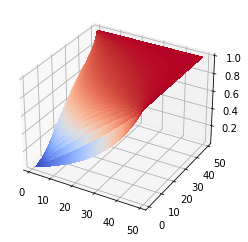

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

V = 50
p = 0.05

D = np.arange(1, V)
X, Y = np.meshgrid(D, D)
Z = f(V, p, X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

Note the behaviour of the function matches our intuition.  When either vertex - say $i$ - has the largest possible degree ($d_i = V-1$), then it _must_ be connected to all other vertices.  Therefore $\forall j : \mathbf{P} \left( F_{i,j} = 1\right) = 1$.

The code below generates a synthetic network with properties similar to those frequently observed on social media platforms.  The network is, overall, sparsely connected but there are dense pockets of high connectivity embedded within it (the "communities").

In [5]:
# The first entry is for the "non-community" nodes
COMMUNITY_SIZES = [100, 25, 25]

# "Background" probability of connection between any two nodes
INTER_PROBS = 0.05

# Probabilities for intra-community connections.  
# For non-community nodes this is simply the background probability
INTRA_PROBS = [INTER_PROBS, 0.4, 0.4]

G = nx.Graph()

community_id_iter = chain(*[repeat(id, n) for id, n in enumerate(COMMUNITY_SIZES, start=-1)])
node_id_iter_1, node_id_iter_2, node_id_iter_3 = tee(count(), 3)
node_ids_by_community = [{next(node_id_iter_1) for n in range(size)} for size in COMMUNITY_SIZES]

for c in node_ids_by_community:
    for id in c:
        G.add_node(id, community_id=next(community_id_iter))

for community_id, pair in enumerate(zip(COMMUNITY_SIZES, INTRA_PROBS)):
    size, p = pair
    for _ in range(size):
        src = next(node_id_iter_2)
        existing_neighbours = list(G.neighbors(src))
        n_neighbours_to_create = max(int(p * size) - len(existing_neighbours), 0)
        possible_new_neighbours = list(node_ids_by_community[community_id].difference({src}.union(existing_neighbours)))
        for tgt in np.random.choice(possible_new_neighbours, n_neighbours_to_create, replace=False):
            G.add_edge(src, tgt)
            
n_inter_edges = int(INTER_PROBS * (0.5 * G.number_of_nodes()**2 - G.number_of_nodes()))

srcs = np.random.choice(G.number_of_nodes(), n_inter_edges)
tgts = np.random.choice(G.number_of_nodes(), n_inter_edges)

for src, tgt in zip(srcs, tgts):
    G.add_edge(src, tgt)
    
G.remove_edges_from(nx.selfloop_edges(G))

In [6]:
# We'll record the three communities in a CDLib NodeClustering object.  This will be useful later on.
# CDLib is a Community Detection library for graphs.  It contains a lot of useful functionality.
# https://cdlib.readthedocs.io

planted_communities = NodeClustering(node_ids_by_community, graph=G, method_name="Planted Communities")

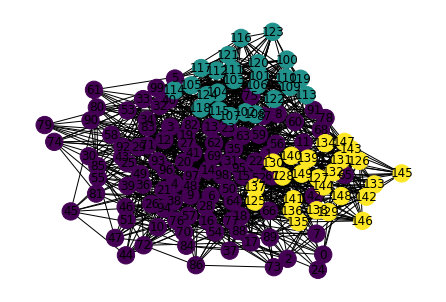

In [7]:
draw(
    G, 
    pos=spring_layout(G, seed=RANDOM_SEED),
    labels={b:b for b in range(G.number_of_nodes())},
    node_color=[G.nodes[n]['community_id'] for n in G.nodes]    
)

Let's assume that we have a matrix, $Q$, containing all the Bernoilli parameters (the connection probabilities).  $Q$ is symmetric (because $\mathbf{P} \left( F_{i,j} = 1\right) = \mathbf{P} \left( F_{j,i} = 1\right)$) and, because no self-connections are allowed, $F_{i,i} = 0$.

Consider the product $Q_{i,k} Q_{j,k}$ where $i \neq j$.  This is the joint probability that both $i$ and $j$ are both connected to $k$.  Given this, we can interpret the (off-diagonal) elements of the matrix product, $QQ$ as the expected number of edges in common between two vertices, $i$ and $j$.  (In what follows we are going to define $\left(QQ\right)_{i,i} = 0$.)

Suppose we measured the actual number of edges that two vertices had in common (call this $N_{i,j}$ where again $N_{i,i} = 0$) and found that it was significantly larger than the corresponding value $\left(QQ\right)_{i,j}$. We'd be surprised at how similar their neighbourhoods were and might conclude that they the two vertices should be part of a community.  Note that this definition does not even require $i$ and $j$ to be connected to each other: they merely have to be embedded near to each other in the graph.

Under our model the $N_{i,j}$ are realisations of a sum of independent Bernoulli trials whose expectation is $Q_{i,j}$.  Such sums are distributed according to a Poisson-Binomial distribution, which has a rather horrific C.D.F:

$$
\mathbf{P} \left(X \leq N_{i,j}\right) = \sum_{l=0}^{N_{i,j}}\sum_{Y \in Z_l}\prod_{y \in Y}Q_{i,y}Q_{j,y}\prod_{\gamma \in Y^c}\left(1-Q_{i,\gamma}Q_{j,\gamma}\right)
$$

where $Z_l$ is the set of all subsets of $l$ integers that can be selected from $\{1,2,3,...,V\}$ and $Y^c$ is the complement of $Y$.  It is clear from this that the compuational cost of evaluating the C.D.F will be prohibitive.  Fortunately _Le Cam's theorum_ states that the P.D.F. of the Poisson binomial can be approximated by the standard Poisson distribution:

$$
\mathbf{P} \left(X = N_{i,j}\right) \sim \text{Poisson}\left(N_{i,j}, \lambda_{i,j}\right) \text{ where } \lambda_{i,j} = \sum_{k=1}^{V} Q_{i,k} Q_{j,k}
$$

Furthermore, Le Cam's theorum places an upper bound on the approximation error:

$$
\sum_{k=0}^{\infty}\left|P\left(N_{i,j}=n\right)-\frac{\lambda_{i,j}^k e^{-\lambda_{i,j}}}{k!}\right| < 2 \sum_{k=1}^{V} Q_{i,k}^2 Q_{j,k}^2
$$

We now have a principled way to test whether two nodes in the graph are "surprisingly" similar.  We simply test whether $Z_{i,j} = \mathbf{P} \left(X \geq N_{i,j} | \lambda_{i,j}\right) \leq \alpha$, where $\alpha$ is our threshold of statistical significance.

Suppose we have a pair of similar nodes, $i$ and $j$ and we create a community $\mathcal{C} = \{i,j\}$.  Under what circumstances should we consider adding another node, $k$, to this community?

One answer would be to require that both $\mathbf{P} \left(X \geq N_{i,k} | \lambda_{i,k}\right) \leq \alpha$ and $\mathbf{P} \left(X \geq N_{j,j} | \lambda_{j,j}\right) \leq \alpha$.  In other words, we require that $k$ passes the "suprisingness test" for all existing members of $\mathcal{C}$.  As a community grows it becomes increasingly difficult to add new members to it.  The condition is too harsh.

Another answer would be to require the community overall to pass a surprisingness test.  Using the fact that Poisson distributions are additive we would require that:

$$
\mathbf{P} \left(X \geq \frac{1}{2} \sum_{c_1 \in \mathcal{C \cup \{k\}}} \sum_{c_2 \in \mathcal{C \cup \{k\}}} N_{c_1,c_2} | \frac{1}{2} \sum_{c_1 \in \mathcal{C \cup \{k\}}} \sum_{c_2 \in \mathcal{C \cup \{k\}}} \lambda_{c_1,c_2}\right) \leq \alpha
$$

But this condition is too weak: it would entail adding a $k$ that was completely disconnected to $\mathcal{C}$ so long as the probability threshold of the community as a whole continued to exceed $\alpha$.

A better solution sits somewhere in the middle.  As $\mathcal{C}$ grows we _expect_ new candidates not to meet our pair-wise test for all existing members - but only for some of them.  Is there a principled way to relax this criterion?

Why yes, there is.  We simply require that enough similarity tests between $k$ and the members of $\mathcal{C}$ pass that we're comfortable that we're not seeing a few chance similarties, but general similarity to the other cluster members.

Let's define $R_{\mathcal{C}, k} = \sum_{c \in \mathcal{C}} Z_{c,k}$.  This quantity should be binomially distributed with $|\mathcal{C}|$ trials and parameter $\alpha$.

So we add $k$ to our community where $\mathbf{P} \left(X \geq R_{\mathcal{C}, k} |  \left|\mathcal{C}\right|, \alpha\right) \leq \alpha$ 

Now to the code.  Which is pretty simple really.

In [8]:
def find_communities(
    G: nx.Graph, 
    alpha: float = 0.05, 
    min_community_size: int = 2
) -> NodeClustering:

    communities = []
    A = adjacency_matrix(G)
    V = G.number_of_nodes()
    E = G.number_of_edges()
    D = A.sum(axis=0).A.ravel()
    P = 2*E / (V*(V-1))
    Q = f(V, P, *np.meshgrid(D, D))
    L = np.matmul(Q, Q.T)
    N = A.dot(A).todense().A
    Z = 1 - poisson.cdf(N-1, L)

    # We turn Z into a masked array.
    # Initially only the Z_ii entries are masked out.
    # As we build communities we will mask out other entries from Z.
    # This will prevent the algorithm from considering unavailable candidates.
    Z = MaskedArray(Z, mask=np.eye(V))

    while True:
        # Find the most similar pair of available nodes
        i, j = np.unravel_index(Z.argmin(), Z.shape)

        if Z[i,j] <= alpha:
            # If the most similar pair is similar enough then it forms the basis of the community
            community = set([i, j])
            Z.mask[i,j] = Z.mask[j,i] = True
        else:
            # If the most similar pair is not similar enough then no more communities can be built
            break

        while True:
            R = (Z[list(community)] <= alpha).sum(axis=0)
            probs = 1 - binom.cdf(k=R-1, n=len(community), p=alpha)

            if (probs <= alpha).sum() == 0:
                # If there are no candidates then this community is complete
                break
            else:
                # Otherwise, add the candidates and mask out the relevant Z entries
                for k in np.where(probs <= alpha)[0]:                
                    community.add(k)

                    for i,j in product(community, [k]):
                        Z.mask[i,j] = Z.mask[j,i] = True

        # Once the community is built, mask out all of it's members
        for c in community:
            Z.mask[c] = Z.mask[:, c] = True

        # Check if it is large enough
        if len(community) >= min_community_size:
            communities.append(community)

    # To be consistent with other community detection algorithms we'll assign all nodes to a community.
    # The first "community" in our returned results will be the "unassigned" nodes.
    assigned = reduce(lambda a,b: a|b, communities, set())
    unassigned = set(range(V)).difference(assigned)
    
    return NodeClustering([unassigned] + communities, G, "Similarity Clustering")

In [9]:
fitted_communities = find_communities(G, 0.05, 5)

In [10]:
# This function adds a fitted community ID to the graph
def label_clusters(G, communities):
    
    def label(n):
        for id, c in enumerate(communities.communities):
            if n in c:
                return id
        return -1
    
    for n in G.nodes():
        G.add_node(n, fitted_community_id=label(n))

In [11]:
label_clusters(G, fitted_communities)

Now we can draw the original graph (top) and the graph with fitted communities (bottom).

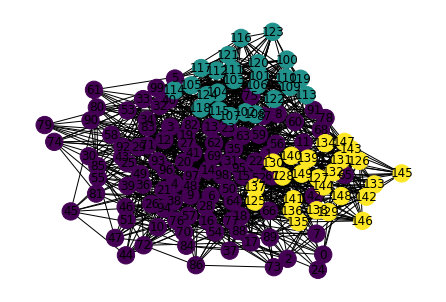

In [12]:
draw(
    G, 
    pos=spring_layout(G, seed=RANDOM_SEED),
    labels={b:b for b in range(G.number_of_nodes())},
    node_color=[G.nodes[n]['community_id'] for n in G.nodes]    
)

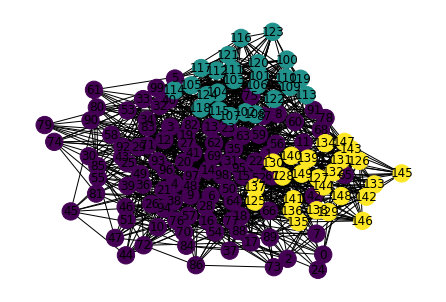

In [13]:
draw(
    G, 
    pos=spring_layout(G, seed=RANDOM_SEED),
    labels={b:b for b in range(G.number_of_nodes())},
    node_color=[G.nodes[n]['fitted_community_id'] for n in G.nodes]    
)

We can evaluate the performance of the algorithm using some standard benchmarks:

1. The Adjusted Rand Index (https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index)
2. The Adjusted Mutual Informatio (https://en.wikipedia.org/wiki/Adjusted_mutual_information)

Both measure the similarity of two different partitionings of a set into (disjoint) subsets.  
Both measures are defined on the interval $\left(0, 1\right)$.

In [14]:
def print_scores(first_partition, second_partition):
    ARI = adjusted_rand_index(first_partition, second_partition)
    AMI = adjusted_mutual_information(first_partition, second_partition)
    print("Adjusted Rand Index", ARI.score)
    print("Adjusted Mutual Information", AMI.score)

In [15]:
print_scores(planted_communities, fitted_communities)

Adjusted Rand Index 1.0
Adjusted Mutual Information 1.0


For comparison, let's see how a few other community detection algorithms fare on this dataset.

In [16]:
fitted_communities = girvan_newman(G, level=3)
print_scores(planted_communities, fitted_communities)

Adjusted Rand Index 0.527521314688297
Adjusted Mutual Information 0.6402917339303126


In [17]:
fitted_communities = louvain(G, randomize=RANDOM_SEED)
print_scores(planted_communities, fitted_communities)

Adjusted Rand Index 0.5816285599679102
Adjusted Mutual Information 0.7939857729164158


In [18]:
fitted_communities = markov_clustering(G)
print_scores(planted_communities, fitted_communities)

Adjusted Rand Index 0.11219608274355371
Adjusted Mutual Information 0.19102558590146837


In [19]:
fitted_communities = chinesewhispers(G, seed=RANDOM_SEED)
print_scores(planted_communities, fitted_communities)

Adjusted Rand Index 0.5538922155688623
Adjusted Mutual Information 0.6802226136791641


Similarity Clustering wins!  Playing with the planted graph a little can cause big differences in the performance of the comparator algorithms.  Similarity Clustering is the best in the handful of setups I've tried.  Clearly more exploration to do here to figure our where it performs well and where it starts to fail.